In [59]:
%load_ext autoreload
%autoreload 2

import datetime
import numpy as np
import scipy as sp
import pandas as pd
import functools as fts
import multiprocessing as mp
from tqdm.notebook import tqdm
from tqdm.contrib import tzip, tenumerate, tmap

from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.storagelevel import StorageLevel
from pyspark.sql.functions import col
import pyspark.sql.types as pstype
import pyspark.sql.functions as F
import pyspark as ps

import matplotlib as mlt
import matplotlib.pyplot as plt
from matplotlib.animation import ArtistAnimation
from IPython.display import HTML
import japanize_matplotlib

from time_series_model import *

%matplotlib inline
%matplotlib ipympl

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
np.set_printoptions(threshold=100, precision=4, linewidth=10000)

In [2]:
SPECIFIED_PATH = "csv_data/"
SPECIFIED_DATE = "20240918"
SPECIFIED_CSV  = SPECIFIED_PATH + SPECIFIED_DATE

In [3]:
pd_data = pd.read_csv(SPECIFIED_CSV + "_urp_data.csv")
pd_data

,x_data
0,-1445.659118
1,-1431.652989
2,-1453.251697
3,-1427.793518
4,-1431.507300
...,...
495,-1137.313245
496,-1155.880759
497,-1137.128868
498,-1151.405290


各時系列軸の係数： [[0.73466544]]
切片の係数： [[-370.16929374]]
1次トレンドの係数： [[0.13689998]]
2次トレンドの係数： [[0.]]
t値： -8.769165084688257
p値： 1.2135167217202668e-12
DF検定(有意水準5%)： True


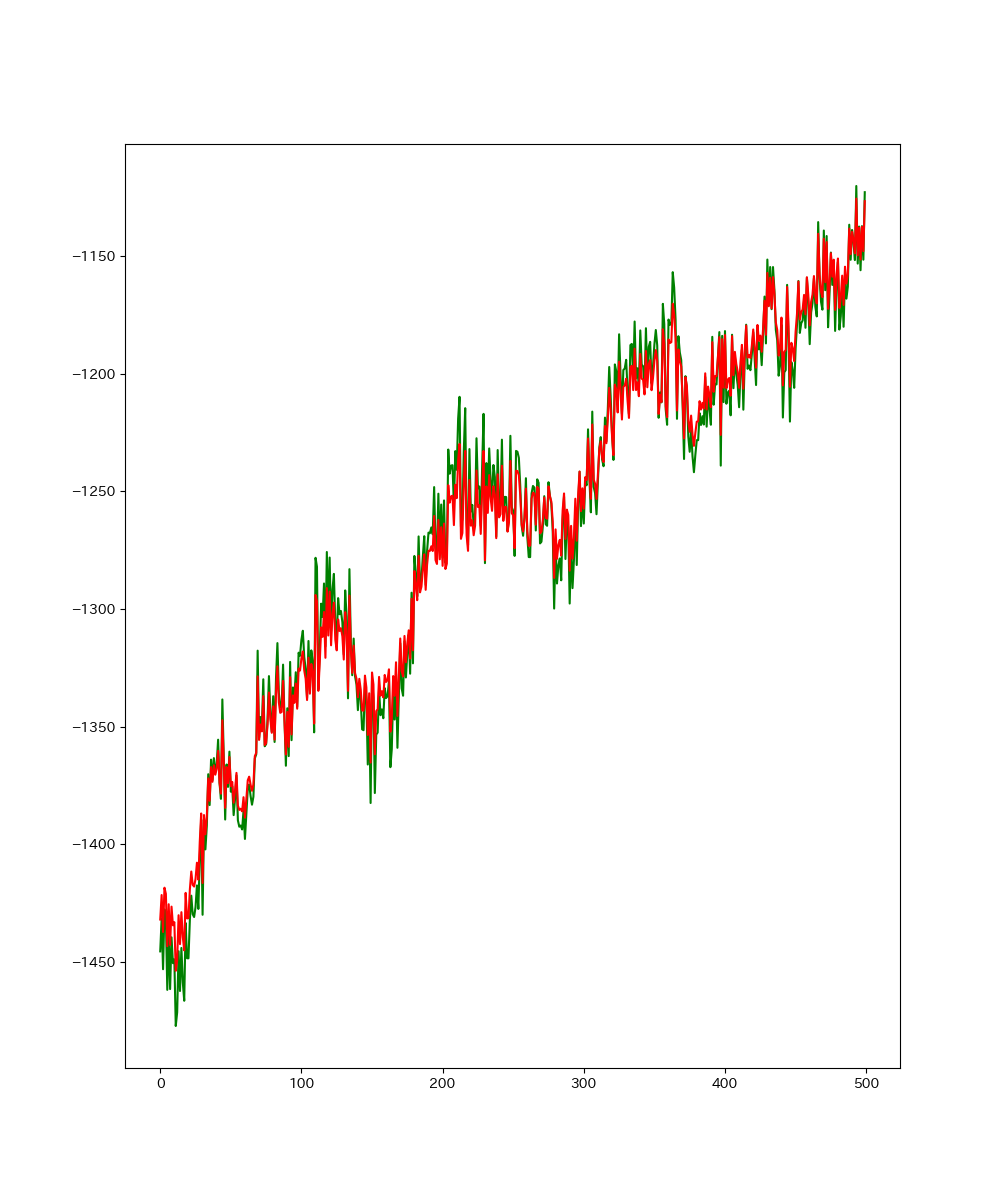

In [4]:
# regression：データ構造により以下から指定
# n  ・・・定数項なし&トレンドなし
# c  ・・・定数項あり&トレンドなし
# ct ・・・定数項あり&1次のトレンドあり
# ctt・・・定数項あり&1次のトレンドあり&2次のトレンドあり
dfruler = Dickey_Fuller_Test(pd_data, regression="ct")
dfruler.fit()
dfruler.dfRuller()
y_pred = dfruler.predict(pd_data, np.arange(1, len(pd_data)+1).reshape([len(pd_data), 1]))

plt.figure(figsize=(10, 12))
plt.plot(pd_data[-len(y_pred):], "-", color="green")
plt.plot(y_pred,                 "-", color="red")

print("各時系列軸の係数：", dfruler.alpha)
print("切片の係数：", dfruler.alpha0)
print("1次トレンドの係数：", dfruler.trend_1st)
print("2次トレンドの係数：", dfruler.trend_2nd)
print("t値：", dfruler.tvalue)
print("p値：", dfruler.pvalue)
print("DF検定(有意水準5%)：", True if dfruler.pvalue < 0.05 else False)

AR model | aic
AR(1) | 5.683756154296333
AR(2) | 5.5846100263972005
AR(3) | 5.548736918098181
AR(4) | 5.514736802224236
AR(5) | 5.506605281135706
AR(6) | 5.509534102753391
AR(7) | 5.512422690620634
AR(8) | 5.514622520278747
AR(9) | 5.5187006142094255
AR(10) | 5.5214477814725225
AR(11) | 5.524799298425078
AR(12) | 5.528832267968644
AR(13) | 5.5304354700245115
AR(14) | 5.522622574103977
AR(15) | 5.525485148945424
AR(16) | 5.527096157778672
AR(17) | 5.531041601457019
AR(18) | 5.5309375450956315
AR(19) | 5.534742049722413
AR(20) | 5.538688546858593
selected orders | 5
各時系列軸の係数： [[ 0.91413219 -0.69975668 -0.51701386 -0.2774092  -0.10941381  0.11082775]]
切片の係数： [[-117.42634674]]
1次トレンドの係数： [[0.04121203]]
2次トレンドの係数： [[0.]]
t値： [ -3.01725643 -33.81554952 -25.76528559 -20.78721779 -19.57571641
 -19.85275018  -2.97893531 -61.8607629 ]
p値： 0.12732022266992288
ADF検定(有意水準5%)： False


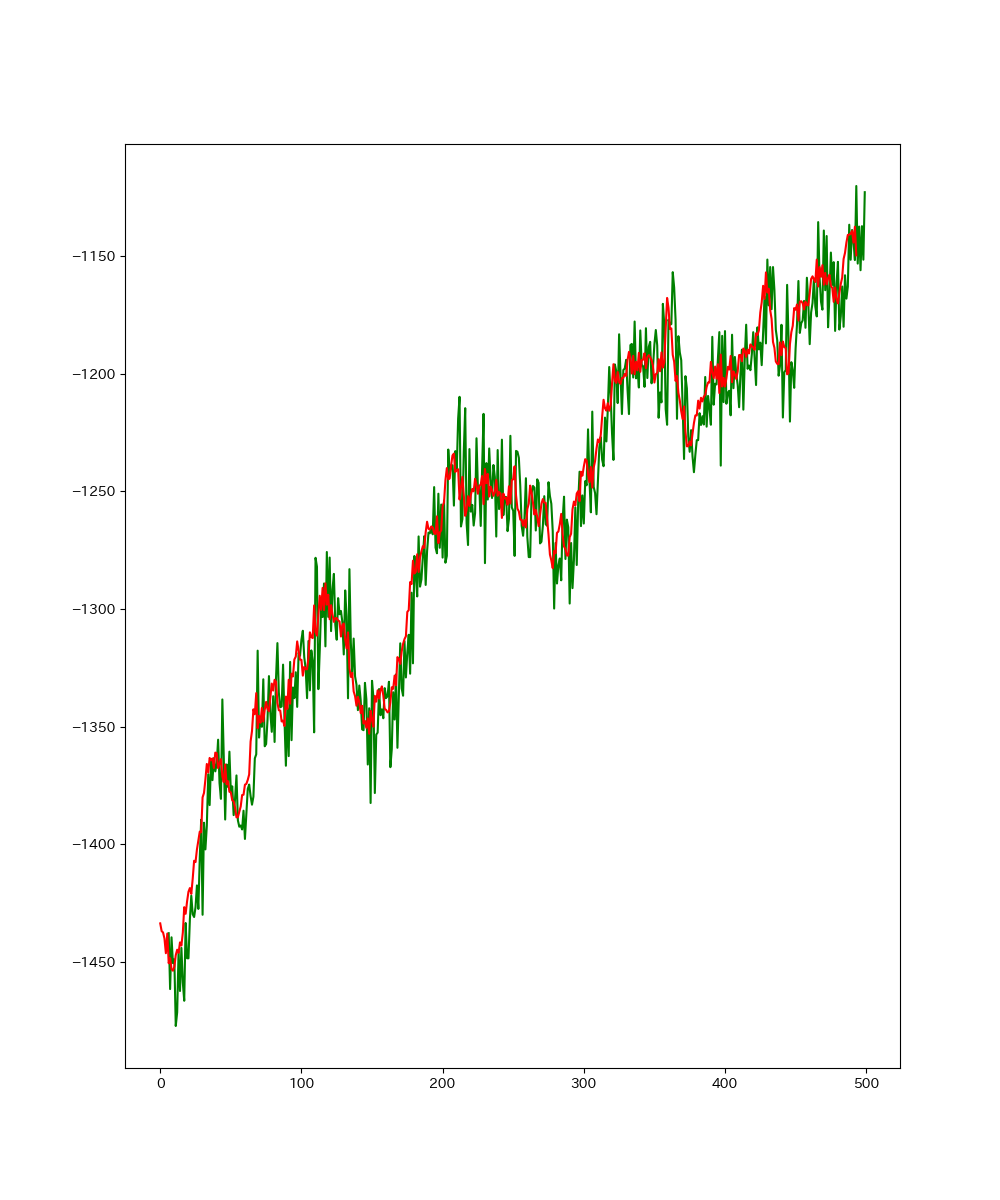

In [5]:
# regression：データ構造により以下から指定
# n  ・・・定数項なし&トレンドなし
# c  ・・・定数項あり&トレンドなし
# ct ・・・定数項あり&1次のトレンドあり
# ctt・・・定数項あり&1次のトレンドあり&2次のトレンドあり
adfruler = Augmented_Dickey_Fuller_Test(pd_data, regression="ct")
adfruler.select_order(maxlag=20, ic="aic", isVisible=True)
adfruler.adfRuller()
y_pred = adfruler.predict(pd_data, np.arange(1, len(pd_data)+1).reshape([len(pd_data), 1]))

plt.figure(figsize=(10, 12))
plt.plot(pd_data[-len(y_pred):], "-", color="green")
plt.plot(y_pred,                 "-", color="red")

print("各時系列軸の係数：", adfruler.alpha.T)
print("切片の係数：", adfruler.alpha0)
print("1次トレンドの係数：", adfruler.trend_1st)
print("2次トレンドの係数：", adfruler.trend_2nd)
print("t値：", adfruler.tvalue)
print("p値：", adfruler.pvalue)
print("ADF検定(有意水準5%)：", True if adfruler.pvalue < 0.05 else False)

In [ ]:
np.set_printoptions(linewidth=10000, threshold=10000)
print(adfruler.train_data)

  0%|          | 0/1000000 [00:00<?, ?it/s]

(array([8.12221619e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        8.12221619e-03, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

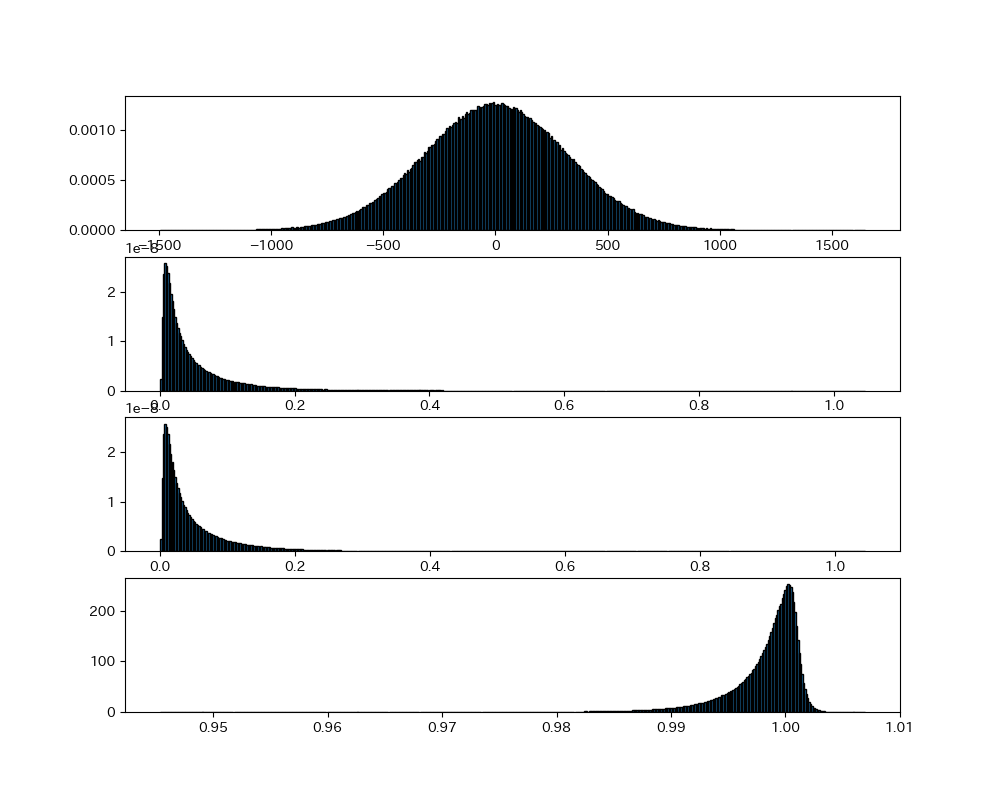

In [10]:
# regression：データ構造により以下から指定
# n  ・・・定数項なし&トレンドなし
# c  ・・・定数項あり&トレンドなし
# ct ・・・定数項あり&1次のトレンドあり
# ctt・・・定数項あり&1次のトレンドあり&2次のトレンドあり

T = 1000
N = 10**6
sigma = 10
const = 50
δ1    = 3
δ2    = 1.1
regression = "n"

save_x  = np.empty([0]) #1次元から配列生成:保存用
save_xx = np.empty([0]) #1次元から配列生成:保存用
save_x2 = np.empty([0]) #1次元から配列生成:保存用
save_ρ  = np.empty([0]) #1次元から配列生成:保存用

for i in tqdm(range(N)):
    if   regression == "n":
        x = 0
    elif regression in ["c", "ct", "ctt"]:
        x = const
    else:
        raise
    
    xx = 0
    x2 = 0
    t  = 0
    while True:
        dx = np.random.normal(loc=0, scale=sigma)  # 平均、標準偏差
        
        if   regression == "n":
            yt = x + dx
        elif regression == "c":
            yt = x + dx
        elif regression == "ct":
            yt = x + dx + δ1 * t
        elif regression == "ctt":
            yt = x + dx + δ1 * t + δ2 * (t ** 2)
        else:
            raise
        
        x2 = x2 + x * x
        xx = xx + x * yt
        x  = yt
        
        if t > T:
            break
        else:
            t = t + 1
            
    save_x  = np.append(save_x,  x)
    save_xx = np.append(save_xx, xx)
    save_x2 = np.append(save_x2, x2)
    save_ρ  = np.append(save_ρ,  xx / x2)
    

# ヒストグラム
fig = plt.figure(figsize = (10,8))
sturgess = lambda x: 1 + round(np.log2(x))

ax = fig.add_subplot(4, 1, 1)
ax.hist(save_x,  bins=500, histtype='barstacked', ec='black',density=True)

ax = fig.add_subplot(4, 1, 2)
ax.hist(save_xx, bins=500, histtype='barstacked', ec='black',density=True)

ax = fig.add_subplot(4, 1, 3)
ax.hist(save_x2, bins=500, histtype='barstacked', ec='black',density=True)

ax = fig.add_subplot(4, 1, 4)
ax.hist(save_ρ,  bins=500, histtype='barstacked', ec='black',density=True)


In [80]:
import timeit

X = np.random.normal(0, 1, [100, 100])
X = (X.T + X) / 2
modified_cholesky(X)



(array([[ 1.    ,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        [ 0.1202,  1.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        [-0.0369, -0.9393,  1.    , ...,  0.    ,  0.    ,  0.    ],
        ...,
        [-0.1459, -1.7312, 11.8637, ...,  1.    ,  0.    ,  0.    ],
        [-0.1369, -2.428 , 16.8891, ...,  0.1204,  1.    ,  0.    ],
        [-0.5207,  0.2335, -9.5756, ...,  0.2536,  0.6885,  1.    ]]),
 array([[-1.9337,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.487 ,  0.    , ...,  0.    ,  0.    ,  0.    ],
        [ 0.    ,  0.    , -0.0876, ...,  0.    ,  0.    ,  0.    ],
        ...,
        [ 0.    ,  0.    ,  0.    , ...,  7.5   ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    , ...,  0.    , -9.3601,  0.    ],
        [ 0.    ,  0.    ,  0.    , ...,  0.    ,  0.    , -0.6901]]))